# Markov Chain Monte Carlo in Practice

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
import os.path
import subprocess
from sklearn import neighbors
import warnings
warnings.filterwarnings('ignore')

## <span style="color:Orange">Markov Chain Monte Carlo</span>

___<span style="color:violet">Markov-chain Monte Carlo___ (MCMC) is an algorithm to generate random samples from an un-normalized probability density.  In other words, you want sample from $P(\vec{z})$ but can only evaluate $f(\vec{z})$ where the two are related by

$$ \Large
P(\vec{z}) = \frac{f(\vec{z})}{\int d\vec{z}\,f(\vec{z})} \; .
$$

Note that $0 \le P(\vec{z}) \le 1$ requires that $f(\vec{z}) \ge 0$ everywhere and that the integral has a non-zero finite value.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

### <span style="color:Lightgreen">Examples</span>

We will start with some simple motivating examples before diving into the Bayesian applications and the theory of Markov chains.

The function

$$ \Large
f(z) = \begin{cases}
\sqrt{1 - z^4} & |z| < 1 \\
0 & |z| \ge 1
\end{cases}
$$

is never negative and has a finite integral:

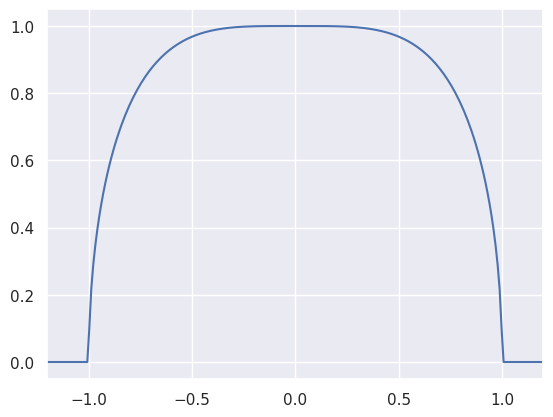

In [2]:
def plotf(zlim=1.2):
    z = np.linspace(-zlim, +zlim, 250)
    plt.plot(z, np.sqrt(np.maximum(0, 1 - z ** 4)))
    plt.xlim(-zlim, +zlim)

plotf()

However, the normalization integral cannot be evaluated analytically (it is related to the [complete elliptic integral of the first kind](https://en.wikipedia.org/wiki/Elliptic_integral#Complete_elliptic_integral_of_the_first_kind)), so this is a good candidate for MCMC sampling using the `MCMC_sample` function (which wraps [emcee](http://dfm.io/emcee/)):

In [3]:
import functools
import inspect
import emcee

def wrap(func, **kwargs):
    """Prepare an arbitrary function to use with emcee sampling.

    Emcee expects its parameters in a single list, but it is sometimes more
    convenient to write a function in terms of named parameters and
    hyperparameters. This method uses introspection to wrap an arbitrary
    function with named parameters so that it has the signature expected
    by emcee.

    For example:

        def f(x,y,a,b): ...
        wrap(f, x=[1], y=[2], a=3, b=4, c=3, d=4)

    returns a tuple (wrapped, ['x','y'], [1,2], {'c':3, 'd':4}) where:

      - wrapped([p,q]) calls f(x=p,y=q,a=3,b=4)
      - [1,2] are the initial values to use for parameters named ['x','y'].
      - {'c':3, 'd':4} are the input kwargs with args of f() removed.

    The square brackets identify floating arguments and specify their initial
    value. An optional callable to evaluate a log-prior can also be passed,
    for example:

        wrap(f, x=[1,px], y=[2,py], a=3, b=4, c=3, d=4)

    where px(x) and py(y) return the (un-normalized) log of the priors on
    x and y to use during posterior sampling.

    Parameters
    ----------
    func : callable
        The function that should be prepared. It is assumed to have only
        numerical arguments that accept any floating point values.
    **kwargs : keyword arguments
        All arguments of func must be included and assigned a value.
        Arguments assigned a floating point value are considered fixed
        during sampling.  Arguments assigned a floating point value
        within a list, e.g., [1.2], will be sampled using the initial
        value provided.  Sampled arguments can optionally also specify
        a log-prior distribution using, e.g. [1.2, lnprior], where lnprior
        is a function of the sampled argument that returns the log prior
        probability density (which does not need to be normalized).

    Returns
    -------
    tuple
        Tuple (wrapped, names, values, kwargs). See example above for details.
    """
    fixed = {}
    names, values, lnpriors = [], [], []
    funcsig = inspect.signature(func)
    try:
        funcargs = {name: kwargs[name] for name in funcsig.parameters}
    except KeyError:
        raise ValueError('Missing arguments.')
    bound = funcsig.bind(**funcargs)
    bound.apply_defaults()
    NoPrior = lambda x: 0.
    for name, value in bound.arguments.items():
        if isinstance(value, list):
            names.append(name)
            values.append(value.pop(0))
            lnpriors.append(value.pop(0) if value else NoPrior)
            if value:
                raise ValueError('Invalid syntax for argument {}.'.format(name))
        else:
            fixed[name] = value
    partial = functools.partial(func, **fixed)
    def wrapped(theta):
        if len(theta) != len(names):
            raise ValueError('expected list of {} values.'.format(len(names)))
        result = 0.
        for lnprior, value in zip(lnpriors, theta):
            result += lnprior(value)
            if not np.isfinite(result):
                # theta is not allowed by this prior.
                return -np.inf
        args = dict(zip(names, theta))
        result += partial(**args)
        return result
    # Remove function args from kwargs.
    for name in funcargs:
        kwargs.pop(name, None)
    return wrapped, names, values, kwargs


def sample(func, names, values, nwalkers=20, nsamples=1000, abs_rms=1e-4,
           frac_rms=1e-3, burnin=100, random_state=None):
    """Generate MCMC samples of the un-normalized PDF func() using emcee.

    Can be used standalone but intended to work with :func:`wrap`.

    Initial values for each walker are Gaussian samples centered on the
    input values with an RMS of max(abs_rms, frac_rms * values).

    Parameters
    ----------
    func : callable
        Evaluate the log PDF to sample. Passed a single list of parameter
        values. Can be prepared using :func:`wrap`.
    names : iterable
        List of names for each floating parameter.  Used to label columns
        in the returned DataFrame. Can be prepared using :func:`wrap`.
    values : iterable
        List of initial values for each floating parameter.  Used to center
        random initial values for each walker. Can be prepared using
        :func:`wrap`.
    nwalkers : int
        The number of emcee walkers to use.
    nsamples : int
        The total number of samples to return, after combining walkers
        and trimming initial burnin.
    abs_rms : float
        Used to set walker initial values.  See above for details.
    rel_rms : float
        Used to set walker initial values.  See above for details.
    burnin : int
        The number of samples to remove from each walker's chain.
    random_state : np.random.RandomState or None
        The random state to use for reproducible chains.

    Returns
    -------
    pandas.DataFrame
        Generated samples in a dataframe, using the inputs names for columns.
    """
    if random_state is None:
        random_state = np.random.RandomState()
    # Generate sampler starting points.
    ndim = len(names)
    values = np.array(values, float)
    initial = np.tile(values, (nwalkers, 1))
    rms = np.maximum(abs_rms, frac_rms * values)
    initial += rms * random_state.normal(size=(nwalkers, ndim))
    # Initialize and run sampler.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, func)
    n_per_chain = 1 + nsamples // nwalkers + burnin
    sampler.run_mcmc(initial, n_per_chain, rstate0=random_state.get_state())
    # Remove burnin and return results in a DataFrame.
    chain = sampler.chain[:, burnin:].reshape(-1, ndim)[:nsamples]
    return pd.DataFrame(chain, columns=names)


def MCMC_sample(func, **kwargs):
    """Generate random samples from an un-normalized PDF.

    See :func:`wrap` and :func:`sample` for details.

    Parameters
    ----------
    func : callable
        Function to evaluate log(f(...)) where f(...) is proportional
        to the desired probability density.  Will be wrapped to
        determine which arguments are sampled and which are fixed.
    **kwargs : keyword arguments
        Used to configure the wrapping of func and the sampler.

    Returns
    -------
    pandas.DataFrame
        Generated samples in a dataframe, with one named column per
        sampled argument of the input function.
    """
    # Wrap the input function.
    wrapped, names, values, kwargs = wrap(func, **kwargs)
    # Generate emcee samples.
    return sample(wrapped, names, values, **kwargs)

In [4]:
def logf(z):
    return 0.5 * np.log(1 - z ** 4) if np.abs(z) < 1 else -np.inf

gen = np.random.RandomState(seed=123)
samples = MCMC_sample(logf, z=[0], nsamples=20000, random_state=gen)

The notation `z=[0]` identifies `z` as the parameter we want to sample (starting the value 0). The result is a Pandas DataFrame of generated samples:

In [5]:
samples[:5]

,z
0,0.062330
1,0.047944
2,-0.229985
3,0.061017
4,0.181863


The generated samples are (approximately) drawn from the normalized $P(z)$ corresponding to the $f(z)$ provided:

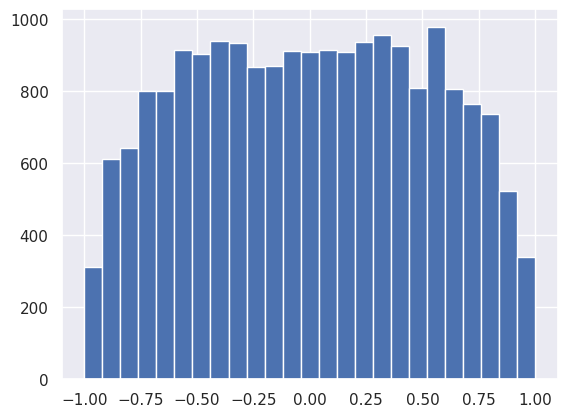

In [6]:
plt.hist(samples['z'], range=(-1,1), bins=25)
plt.show()

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

What are MCMC samples good for? They allow us to estimate the expectation value of an arbitrary $g(z)$ using [importance sampling](https://en.wikipedia.org/wiki/Importance_sampling):

$$ \Large
\langle g(\vec{z})\rangle_P \equiv \int d\vec{z}\, g(\vec{z})\, P(\vec{z})
\simeq \frac{1}{N} \sum_{i=1}^N g(\vec{z}_i) \; ,
$$

where $\vec{z}_1, \vec{z}_2, \ldots$ are the MCMC samples.

For example, to estimate the expectation value of $g(z) = z^2$ (aka the variance) with the samples generated above:

In [7]:
np.mean(samples['z'] ** 2)

np.float64(0.2729666505147651)

Expectation values of more complex functions are equally easy, for example, $g(z) = \sin(\pi z)^2$,

In [8]:
np.mean(np.sin(np.pi * samples['z']) ** 2)

np.float64(0.5414157152385632)

You can also build an empirical estimate of the normalized probability density $P(\vec{z})$ using any density estimation method, for example:

In [9]:
fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.01).fit(samples)

mean P(z)/f(z) = 1.761


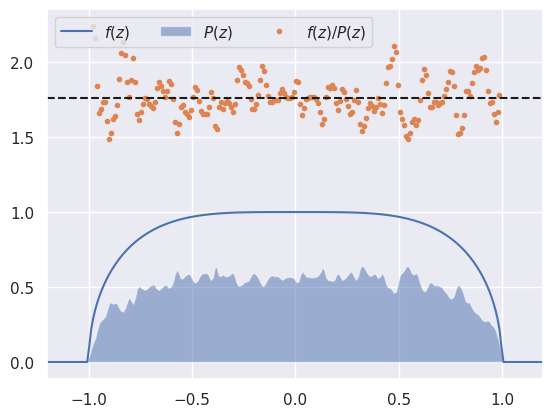

In [10]:
def plotfit(zlim=1.2, Pmin=0.1):
    z = np.linspace(-zlim, +zlim, 250)
    f = np.sqrt(np.maximum(0, 1 - z ** 4)) # f = unnormalized function (numerator)
    P = np.exp(fit.score_samples(z.reshape(-1, 1))) # P = normalized (through KDE) function from samples  
    plt.plot(z, f, label='$f(z)$')
    plt.fill_between(z, P, alpha=0.5, label='$P(z)$')
    ratio = f / P # estimate of normalization integral
    sel = P > Pmin
    plt.plot(z[sel], ratio[sel], '.', label='$f(z)/P(z)$')
    mean_ratio = np.mean(ratio[sel])
    print('mean P(z)/f(z) = {:.3f}'.format(mean_ratio))
    plt.axhline(mean_ratio, ls='--', c='k')
    plt.xlim(-zlim, +zlim)
    plt.legend(loc='upper left', ncol=3)

plotfit()

The estimated $P(z)$ does not look great, but since it is just a scaled version of the smooth un-normalized $f(z)$, their ratio at each $z$ is an estimate of the integral:

$$ \Large
\frac{f(z)}{P(z)} = \int dz\,f(z) \; .
$$

Therefore the mean of $f(z) / P(z)$ provides an estimate of the normalization integral.  In practice, we restrict this mean to $z$ values where $P(z)$ is above some minimum to avoid regions where the empirical density estimate is poorly determined.

In the example above, the true value of the integral rounds to 1.748 so our numerical accuracy is roughly 1%.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

Next, we try a multidimensional example:

$$ \Large
f(\vec{z}, \vec{z}_0, r) =
\begin{cases}
\exp\left(-|\vec{z} - \vec{z}_0|^2/2\right) & |\vec{z}| < r \\
0 & |\vec{z}| \ge r
\end{cases}
$$

This function describes an un-normalized Gaussian PDF centered at $\vec{z}_0$ and clipped outside $|\vec{z}| < r$. The normalization integral has no analytic solution except in the limits $\vec{z}_0\rightarrow \vec{z}$ or $r\rightarrow\infty$.

To generate MCMC samples in 2D:

In [11]:
def logf(x, y, x0, y0, r):
    z = np.array([x, y])
    z0 = np.array([x0, y0])
    return -0.5 * np.sum((z - z0) ** 2) if np.sum(z ** 2) < r ** 2 else -np.inf

The variables to sample are assigned initial values in square brackets and all other arguments are treated as fixed hyperparameters:

In [12]:
samples = MCMC_sample(logf, x=[0], y=[0], x0=1, y0=-2, r=3, nsamples=10000)

The generated samples now have two columns:

In [13]:
samples[:5]

,x,y
0,0.806058,-2.750167
1,0.806058,-2.750167
2,0.980924,-2.583978
3,0.980924,-2.583978
4,0.980924,-2.583978


A scatter plot shows a 2D Gaussian distribution clipped to a circle and offset from its center, as expected:

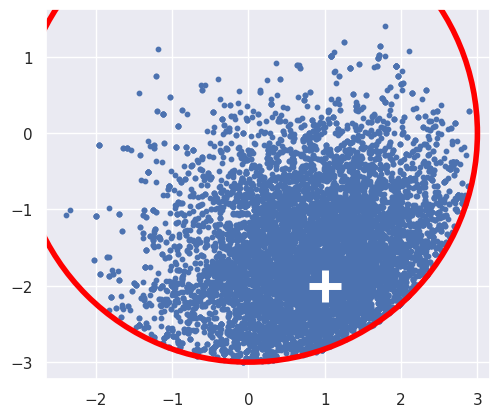

In [14]:
plt.scatter(samples['x'], samples['y'], s=10)
plt.scatter(1, -2, marker='+', s=500, lw=5, c='white')
plt.gca().add_artist(plt.Circle((0, 0), 3, lw=4, ec='red', fc='none'))
plt.gca().set_aspect(1)

With multidimensional samples, we can estimate expectation values of marginal PDFs just as easily as the full joint PDF.  In our 2D example, the marginal PDFs are:

$$ \Large
P_X(x) = \int dy\, P(x, y) \quad , \quad P_Y(y) = \int dx\, P(x, y) \; .
$$

For example, the expectation value of $g(x)$ with respect to $P_X$ is:

$$ \Large
\langle g\rangle \equiv \int dx\, g(x) P_X(x) = \int dx\, g(x) \int dy\, P(x, y) = \int dx dy\, g(x)\, P(x,y) \; .
$$

In other words, the expectation value with respect to a marginal PDF is equal to the expectation with respect to the full joint PDF.

For example, the expectation value of $g(x) = x$ (aka the mean) with respect to $P_X(x)$ is:

In [15]:
np.mean(samples['x'])

np.float64(0.815363355894724)

We can also estimate the density of a marginal PDF by simply dropping the columns that are integrated out before plugging into a density estimator.  For example:

In [16]:
fitX = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(samples.drop(columns='y').values)
fitY = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(samples.drop(columns='x').values)

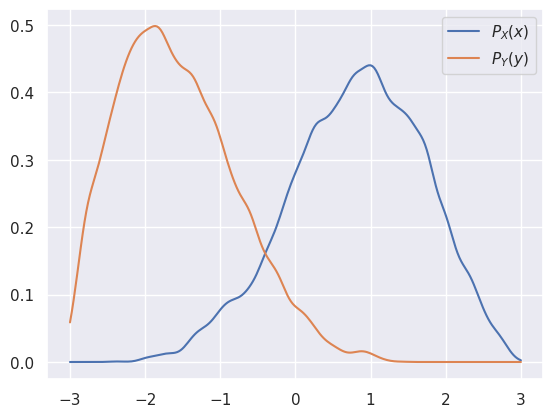

In [17]:
def plotfitXY(r=3):
    xy = np.linspace(-r, +r, 250)
    Px = np.exp(fitX.score_samples(xy.reshape(-1, 1)))
    Py = np.exp(fitY.score_samples(xy.reshape(-1, 1)))
    plt.plot(xy, Px, label='$P_X(x)$')
    plt.plot(xy, Py, label='$P_Y(y)$')
    plt.legend()
    
plotfitXY()

### <span style="color:Lightgreen">Bayesian Inference with MCMC</span>


We introduced MCMC above as a general purpose algorithm for sampling any un-normalized PDF, without any reference to Bayesian (or frequentist) statistics. We also never specified whether $\vec{z}$ was something observed (data) or latent (parameters and hyperparameters), because it doesn't matter to MCMC.

However, MCMC is an excellent tool for performing numerical inferences using the generalized Bayes' rule we met earlier:

$$ \Large
P(\Theta_M\mid D, M) = \frac{P(D\mid \Theta_M, M)\,P(\Theta_M\mid M)}{P(D\mid M)}
$$

In particular, the normalizing denominator (aka the "evidence"):

$$ \Large
P(D\mid M) = \int d\Theta_M' P(D\mid \Theta_M', M)\, P(\Theta_M'\mid M)
$$

is often not practical to calculate, so we can only calculate the un-normalized numerator

$$ \Large
P(D\mid \Theta_M, M)\,P(\Theta_M\mid M) \; ,
$$

which combines the *likelihood of the data* and the *prior probability of the model*.

If we treat the observed data $D$ and hyperparameters $M$ as fixed, then the appropriate function to plug into an MCMC is:

$$ \Large
\log f(\Theta) = \log P(D\mid \Theta_M, M) + \log P(\Theta_M\mid M) \; .
$$

The machinery described above then enables us to generate samples $\Theta_1, \Theta_2, \ldots$ drawn from the *posterior* distribution, and therefore make interesting statements about probabilities involving model parameters.

The likelihood function depends on the data and model, so could be anything, but we often assume Gaussian errors in the data, which leads to the multivariate Gaussian PDF we met earlier ($d$ is the number of data features):

$$ \Large
P(\vec{x}\mid \Theta_M, M) =
\left(2\pi\right)^{-d/2}\,\left| C\right|^{-1/2}\,
\exp\left[  -\frac{1}{2} \left(\vec{x} - \vec{\mu}\right)^T C^{-1} \left(\vec{x} - \vec{\mu}\right) \right]
$$

In the most general case, $\vec{\mu}$ and $C$ are functions of everything: the data $D$, the parameters $\Theta_M$ and the hyperparameters $M$.

When we have $N$ independent observations, $\vec{x}_1, \vec{x}_2, \ldots$, their combined likelihood is the product of each sample's likelihood:

$$ \Large
P(\vec{x}_1, \vec{x}_2, \ldots\mid \Theta_M, M) = \prod_{i=1}^N\, P(\vec{x}_i\mid \Theta_M, M)
$$

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:violet">EXAMPLE</span>___: Consider fitting a straight line $y = m x + b$, with parameters $m$ and $b$, to data with two features $x$ and $y$. The relevant log-likelihood function is:

$$ \Large
\log{\cal L}(m, b; D) = -\frac{N}{2}\log(2\pi\sigma_y^2)
-\frac{1}{2\sigma_y^2} \sum_{i=1}^N\, (y_i - m x_i - b)^2 \; ,
$$

where the error in $y$, $\sigma_y$, is a fixed hyperparameter. Note that the first term is the Gaussian PDF normalization factor.

First generate some data on a straight line with measurement errors in $y$ (so our assumed model is correct):

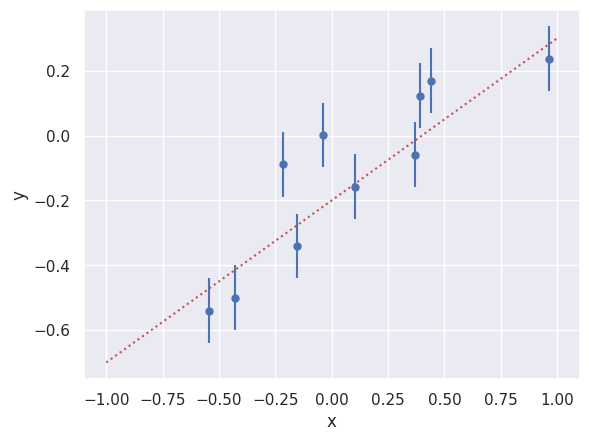

In [18]:
gen = np.random.RandomState(seed=123)
N, m_true, b_true, sigy_true = 10, 0.5, -0.2, 0.1
x_data = gen.uniform(-1, +1, size=N)
y_data = m_true * x_data + b_true + gen.normal(scale=sigy_true, size=N)

plt.errorbar(x_data, y_data, sigy_true, fmt='o', markersize=5)
plt.plot([-1, +1], [-m_true+b_true,+m_true+b_true], 'r:')
plt.xlabel('x'); plt.ylabel('y')
plt.show()

Next, define the log-likelihood function:

In [19]:
def loglike(x, y, m, b, sigy):
    N = len(x)
    norm = 0.5 * N * np.log(2 * np.pi * sigy ** 2)
    return -0.5 * np.sum((y - m * x - b) ** 2) / sigy ** 2 - norm

Finally, generate some MCMC samples of the posterior 

$$ \Large
P(m, b\mid D, M)
$$

assuming uniform priors 

$$ \Large
P(b,m\mid \sigma_y) = 1
$$

as follows:

In [20]:
samples = MCMC_sample(loglike, m=[m_true], b=[b_true],
                      x=x_data, y=y_data, sigy=sigy_true, nsamples=10000, random_state=gen)

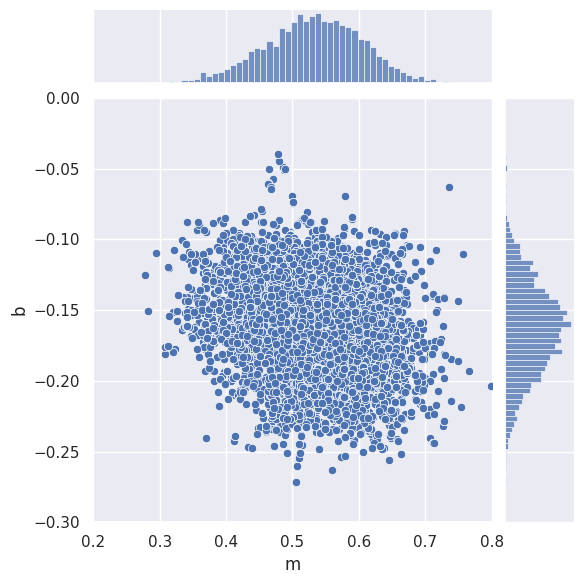

In [21]:
sns.jointplot(data=samples, x='m', y='b', xlim=(0.2,0.8), ylim=(-0.3,0.0))
plt.show()

In [22]:
samples.describe(percentiles=[])

,m,b
count,10000.000000,10000.000000
mean,0.531518,-0.163364
std,0.074150,0.032178
min,0.277887,-0.271737
max,0.799155,-0.039917


<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:violet">EXERCISE</span>___ We always require a starting point to generate MCMC samples. In this example, we used the true parameter values as starting points:
```
m=[m_true], b=[b_true]
```
What happens if you chose different starting points?  Try changing the starting values by $\pm 0.1$ and see how this affects the resulting means and standard deviations for $m$ and $b$.

In [23]:
samples = MCMC_sample(loglike, m=[m_true+0.1], b=[b_true+0.1],
                      x=x_data, y=y_data, sigy=sigy_true, nsamples=10000, random_state=gen)

In [24]:
samples.describe(percentiles=[])

,m,b
count,10000.000000,10000.000000
mean,0.526889,-0.164017
std,0.071437,0.033185
min,0.287060,-0.263188
max,0.800168,-0.051169


In [25]:
samples = MCMC_sample(loglike, m=[m_true-0.1], b=[b_true-0.1],
                      x=x_data, y=y_data, sigy=sigy_true, nsamples=10000, random_state=gen)

In [26]:
samples.describe(percentiles=[])

,m,b
count,10000.000000,10000.000000
mean,0.526197,-0.163166
std,0.073906,0.032095
min,0.287884,-0.272038
max,0.811648,-0.042163


The changes are small compared with the offsets ($\pm 0.1$) and the standard deviations in each parameter.

The `MCMC_sample` function can apply independent (i.e., factorized) priors on each parameter:

$$ \Large
P(\Theta\mid M) = \prod_j P(\theta_j\mid M)
$$

Define the two most commonly used independent priors:

In [27]:
def TopHat(lo, hi):
    """Return un-normalized log(prior) for x in [lo,hi]"""
    return lambda x: 0 if (lo <= x <= hi) else -np.inf

In [28]:
def Gauss(mu, sigma):
    """Return un-normalized log(prior) for x ~ N(mu,sigma)"""
    return lambda x: -0.5 * ((x - mu) / sigma) ** 2

To apply a prior, we replace `z=[value]` with `z=[value,logprior]`.  For example, suppose we believe that $0.4 \le m \le 0.7$:

In [29]:
samples = MCMC_sample(loglike, m=[m_true,TopHat(0.4,0.7)], b=[b_true],
                      x=x_data, y=y_data, sigy=sigy_true, nsamples=10000, random_state=gen)

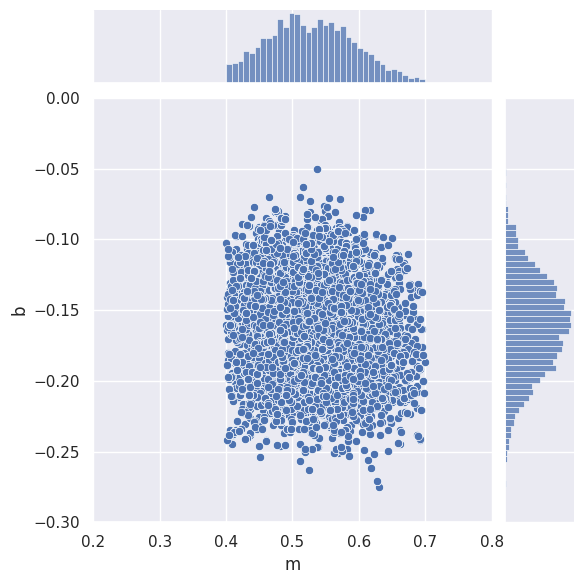

In [30]:
sns.jointplot(data=samples, x='m', y='b', xlim=(0.2,0.8), ylim=(-0.3,0.0))
plt.show()

We can also add a prior on $b$.  For example, suppose a previous measurement found $b = -0.20 \pm 0.02$ (in which case, the new data is not adding much information about $b$):

In [31]:
samples = MCMC_sample(loglike, m=[m_true,TopHat(0.4,0.7)], b=[b_true,Gauss(-0.20,0.02)],
                      x=x_data, y=y_data, sigy=sigy_true, nsamples=10000, random_state=gen)

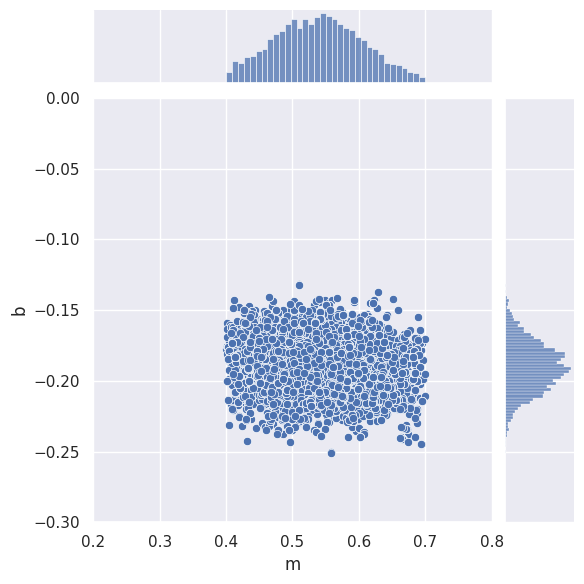

In [32]:
sns.jointplot(data=samples, x='m', y='b', xlim=(0.2,0.8), ylim=(-0.3,0.0))
plt.show()

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:violet">EXERCISE</span>___ Suppose we know that all $y_i$ values have the same error $\sigma_y$ but we do not know its value.
 - Generate samples of $(m, b, \sigma_y)$ using `m=[m_true], b=[b_true], sigy=[sigy_true]`.
 - Look at the samples with an `sns.pairplot`.
 - Which panel shows the marginalized posterior $P(\sigma_y\mid D)$? Do you understand its peculiar shape?
 - Add a prior on $\sigma_y$ to fix this peculiar shape.

In [33]:
samples = MCMC_sample(loglike, m=[m_true], b=[b_true], sigy=[sigy_true],
                      x=x_data, y=y_data, nsamples=10000, random_state=gen)

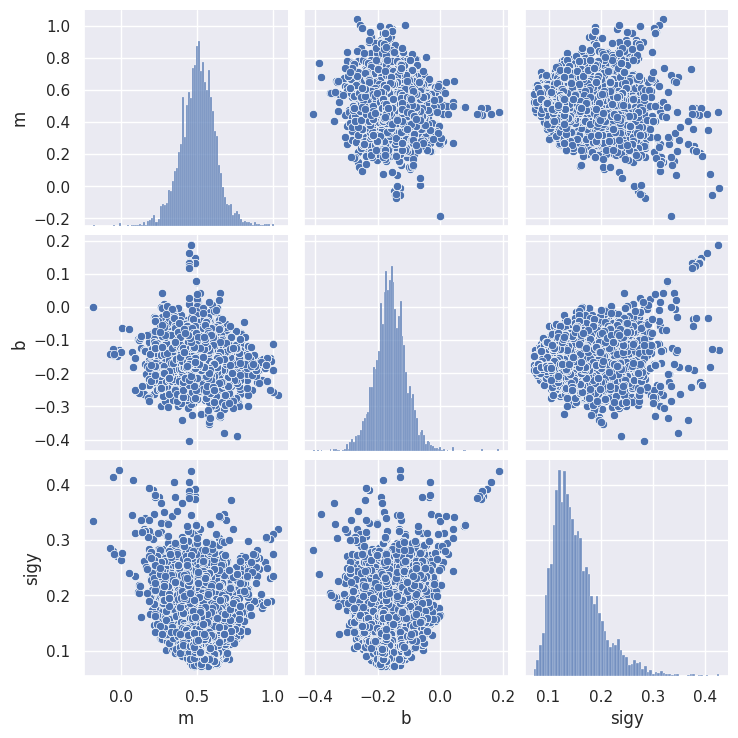

In [34]:
sns.pairplot(samples)
plt.show()

In [35]:
samples = MCMC_sample(loglike, m=[m_true], b=[b_true], sigy=[sigy_true, TopHat(0.01,1)],
                      x=x_data, y=y_data, nsamples=10000, random_state=gen)

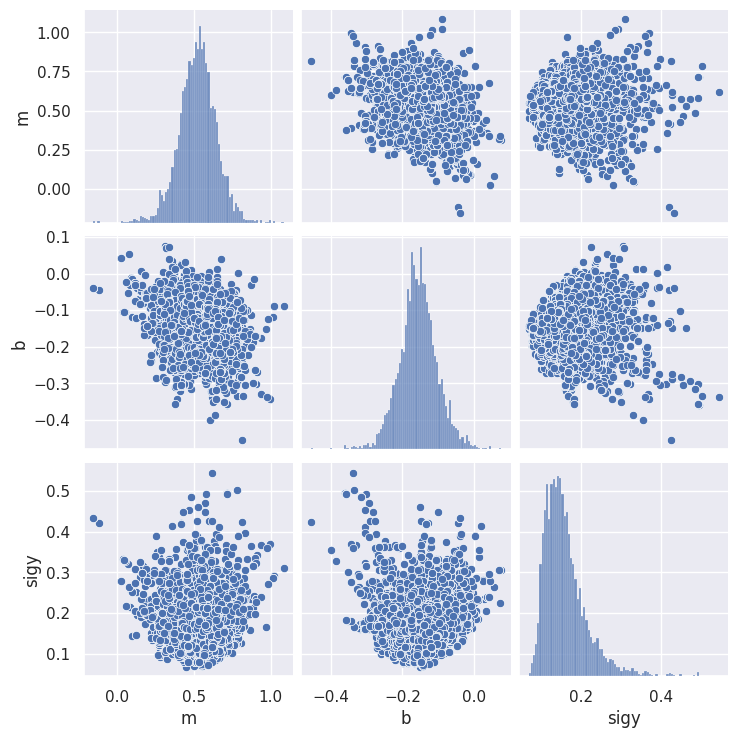

In [36]:
sns.pairplot(samples)
plt.show()

For a more in-depth case study of the many subtleties in fitting a straight line, read this 55-page [article by Hogg, Bovy and Lang](https://arxiv.org/abs/1008.4686).

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2026